# Clustering

## Dimensionality Reduction & LSA
#### Dataset
- **Altitude** - Altitude.MSL.Single Value
- **Distance** - Relative Position.Distance.Nautical Miles
- **Report** - combined narrative and summary stemmed
- **Narrative**
- **Summary**

In [111]:
import numpy as np
import scipy as sp
import pandas as pd
import json as js
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
from sklearn import metrics
import scipy.cluster.hierarchy as hierarchy 
%matplotlib inline

In [112]:
# Read report
new_report = pd.read_csv("02-ASRS-stemmed.csv", index_col=0)
new_report.head()

,Altitude,Distance,Narrative,Report,Summary
0,2500,9.0,F/O FLYING ACFT FROM LEFT SEAT. BLUE AND WHITE...,helicopt encount sma acft IN see avoid situat ...,HELICOPTER ENCOUNTERED SMA ACFT IN SEE AND AVO...
1,4500,22.0,WHILE LEVEL AT 4500'; HDG 246 DEGS ON VICTOR 1...,close prox ga-sma ga-smt ON v106 . level AT 45...,CLOSE PROX GA-SMA GA-SMT ON V106.
2,800,2.0,I WAS INVOLVED IN A NMAC WHILE ON FINAL APCH T...,close prox 2 ga-sma acft IN traffic pattern AT...,CLOSE PROX 2 GA-SMA ACFT IN TRAFFIC PATTERN AT...
3,3500,15.0,WHILE ON CROSS-COUNTRY VFR FROM ORANGE; MA TO ...,close prox GA sma parachutist IN restrict area...,CLOSE PROX GA SMA AND PARACHUTIST IN RESTRICTE...
4,1800,2.0,UPON REACHING MADISON VOR WE REQUESTED CLRNC D...,standard separaton nmac between commut sma acf...,LESS THAN STANDARD SEPARATON AND NMAC BETWEEN ...


In [113]:
# Word reference lookup helper
word_reference = pd.read_csv("02-ASRS-word-reference.csv", index_col=0)
def lookup(word):
    for i in range(len(word_reference)):
        if word_reference['after'][i] == word:
            print(word_reference['before'][i])
            break

lookup('ra')

RAs


In [114]:
# Tfid Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.8)
dtm = vectorizer.fit_transform(new_report['Report'])
print(dtm.shape)
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
terms = vectorizer.get_feature_names()

(571, 1600)


In [115]:
# Decide n_components
svd = TruncatedSVD(n_components=100, algorithm="randomized")
svd_fit = svd.fit_transform(centered_dtm)
svd_norm = Normalizer().fit_transform(svd_fit)

vt = svd.components_
dfnorm = pd.DataFrame(svd_norm)

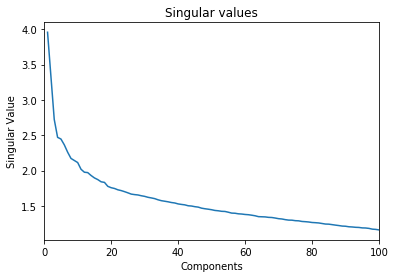

In [116]:
s = svd.singular_values_
plt.xlim([0,100])
plt.plot(range(1,len(s)+1),s)
plt.title('Singular values')
plt.ylabel('Singular Value')
plt.xlabel('Components')

In [117]:
svd = TruncatedSVD(n_components=10, algorithm="randomized")
svd_fit = svd.fit_transform(centered_dtm)
svd_norm = Normalizer().fit_transform(svd_fit)

vt = svd.components_
dfnorm = pd.DataFrame(svd_norm)

In [118]:
order_components = vt.argsort()[:, ::-1]
components = []
for i in range(vt.shape[0]):
    label = [terms[ind] for ind in order_components[i, :10]]
    components.append(label)
dfnorm.columns = components
dfnorm.head()

,tcasii,ft,ra,clb,tfc,atc,dscnt,visual,acr,ta
,acr,sector,issu,radar,ctlr,separ,error,hold,sep,zbw
,acr,twr,rwi,turn,apch,downwind,deg,tcasii,final,hdg
,aircraft,traffic,tower,acr,runway,approach,ra,pilot,downwind,flight
,sma,smt,hdg,deg,apch,clock,vfr,atc,tca,approx
,sma,ra,rptr,tcasii,pattern,acft,acr,radar,final,reveal
,apch,ra,pvd,il,ctl,vector,aircraft,rwi,tower,mht
,ft,sma,10000,9000,acr,mht,4000,5000,3000,glider
,sma,acft,dep,aircraft,traffic,ft,7000,hdg,turn,deg
,clb,visual,separ,dep,sector,maintain,zbw,mht,twr,saab
0,-0.405394,-0.099085,-0.092498,0.002446,0.595246,0.494668,-0.199031,0.156529,0.388994,-0.053201


In [119]:
dfloc = pd.DataFrame(scale(new_report[['Distance', 'Altitude']]), columns=['Distance', 'Altitude'])
df_features = dfloc.join(dfnorm)
df_features['Distance'] = df_features['Distance'].apply(lambda x: x * 1)
df_features['Altitude'] = df_features['Altitude'].apply(lambda x: x * 1)
df_features.to_csv('03-lsa.csv')
df_features.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 10 on the right)
  warnings.warn(msg, UserWarning)


,Distance,Altitude,"(tcasii, acr, acr, aircraft, sma, sma, apch, ft, sma, clb)","(ft, sector, twr, traffic, smt, ra, ra, sma, acft, visual)","(ra, issu, rwi, tower, hdg, rptr, pvd, 10000, dep, separ)","(clb, radar, turn, acr, deg, tcasii, il, 9000, aircraft, dep)","(tfc, ctlr, apch, runway, apch, pattern, ctl, acr, traffic, sector)","(atc, separ, downwind, approach, clock, acft, vector, mht, ft, maintain)","(dscnt, error, deg, ra, vfr, acr, aircraft, 4000, 7000, zbw)","(visual, hold, tcasii, pilot, atc, radar, rwi, 5000, hdg, mht)","(acr, sep, final, downwind, tca, final, tower, 3000, turn, twr)","(ta, zbw, hdg, flight, approx, reveal, mht, glider, deg, saab)"
0,-0.214551,-0.640337,-0.405394,-0.099085,-0.092498,0.002446,0.595246,0.494668,-0.199031,0.156529,0.388994,-0.053201
1,0.237947,-0.373952,-0.365092,0.066521,-0.014807,-0.196864,0.825269,-0.118743,-0.043092,-0.342197,-0.095200,0.011007
2,-0.458203,-0.866764,-0.636730,-0.350115,0.157955,-0.007733,0.015274,0.548814,-0.191010,-0.096506,0.191384,-0.251253
3,-0.005706,-0.507144,-0.583951,-0.033094,-0.477349,0.243328,0.224503,0.256340,-0.041244,0.372872,-0.334157,-0.048250
4,-0.458203,-0.733571,-0.620339,-0.273102,0.405299,-0.467651,0.162705,-0.073600,-0.009241,-0.295947,0.164793,0.104465


## Outlier Detection

In [120]:
# Find 5 outliers for each cluster
from scipy.spatial.distance import euclidean
def outliers(k, labels, centroids, names):
    for cluster_label in range(k):
        print('Cluster', cluster_label, names[cluster_label])
        points = [(index, df_features.values[index][:2]) for index in range(len(labels)) if labels[index] == cluster_label] # (index, location)
        distances = [(p[0], euclidean(centroids[i][:2], p[1])) for p in points] # (index, distance)
        farthest3 = sorted(distances, key=lambda d: d[1], reverse=True)[:3]
        for item in farthest3:
            res = new_report.loc[item[0]]
            print("dropping the following outlier")
            print(res)
            new_report = new_report.drop([item[0]])
            '''
            print('latitude', res['latitude'])
            print('longitude', res['longitude'])
            print('popular categories', res['categories'])
            print('original categories', df_original.loc[item[0]]['categories'])'''
        print()

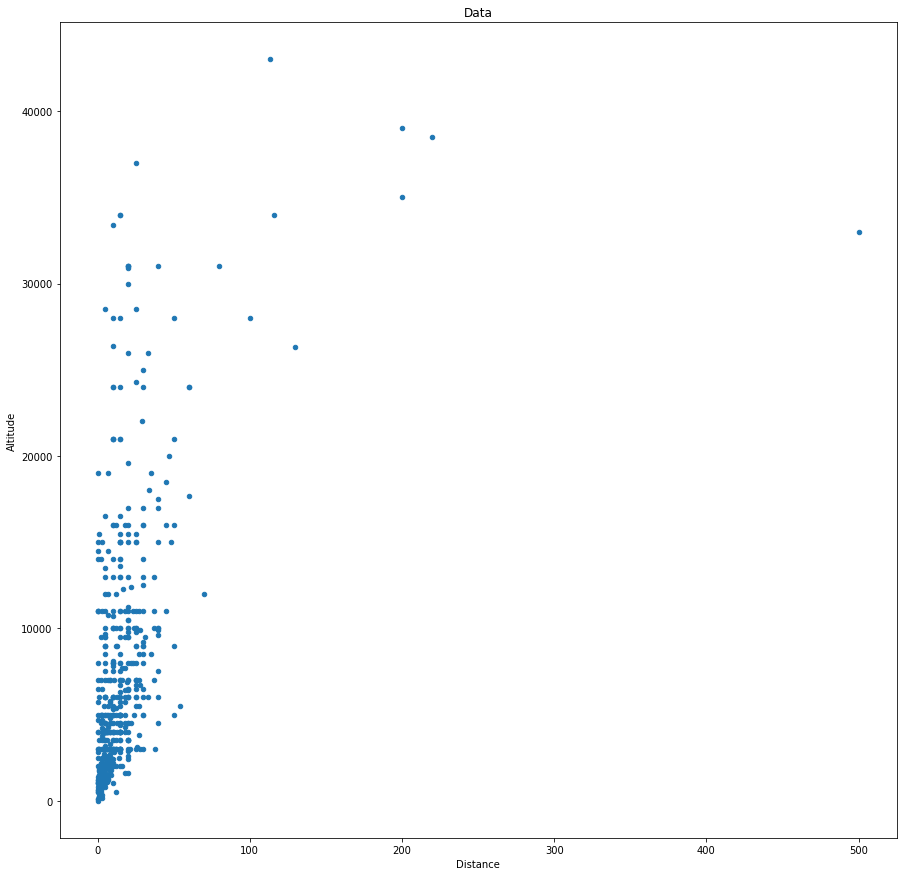

In [121]:
plt.figure(figsize=(15, 15))

dis = new_report['Distance']
alt = new_report['Altitude']
plt.scatter(x=dis, y=alt, s=20)
    
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('Data')
plt.show()

## K-means

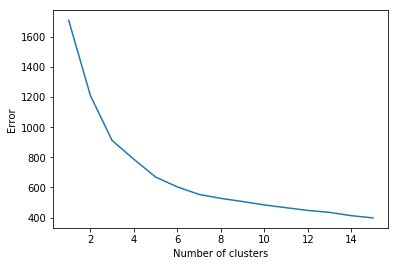

In [122]:
# Use the k-mean++ algorithm to find cluster

# Find out the optimal number of clusters 
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    plt.show()
    
evaluate_clusters(df_features, 15)

From the graph above, we can see that the error reach below 800 after 6 clusters and does not have a huge change after this number. Therefore, we choose 5 as the optimal number of clusters.

In [137]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1)
kmeans.fit_predict(df_features)
Kcentroids = kmeans.cluster_centers_
Klabels = kmeans.labels_
Kerror = kmeans.inertia_
print(Klabels.shape)
print("The total error of the clustering is: {}.".format(Kerror))

(571,)
The total error of the clustering is: 785.3899600471875.


In [138]:
# Name k clusters
Kasc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
Korder_centroids = Kasc_order_centroids[:,::-1]
Korder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Korder_centroids]) # remove locations

Kcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Korder_centroids[i, :2]]
    Kcluster_names.append(label)

In [135]:
#Kcluster_names = ['Traffic Collision Avoidence System / FT / Radar Advisory Service / Climb / Air Traffic Control / Traffic / Visual / accident / descent / true air speed' ,'Traffic / Apching / sector (a portion of an itinerary) / Visual / Control / Bradley International Airport / Boston Air Route Traffic Control Center (ZBW) / climb / jet', 'Aircraft / sector / issue / radar / control / separation / error / holding / sep (single Engine Piston) / hdg (magnetic heading mode)', 'aircraft / sma (a type of engine) / traffic / smt (radial for turning) / tower / runaway / approach / clock / hdg (magnetic heading mode) / atc (air traffic control)', 'Traffic / Apching / sector (a portion of an itinerary) / Visual / Control / Bradley International Airport / Boston Air Route Traffic Control Center (ZBW) / climb / jet']

In [143]:
def find_report(cluster_num):
    report = [new_report.iloc[i]['Summary'] for i in range(len(Klabels)) if Klabels[i] == cluster_num]
    return report

# Sample Report
#find_report(3)

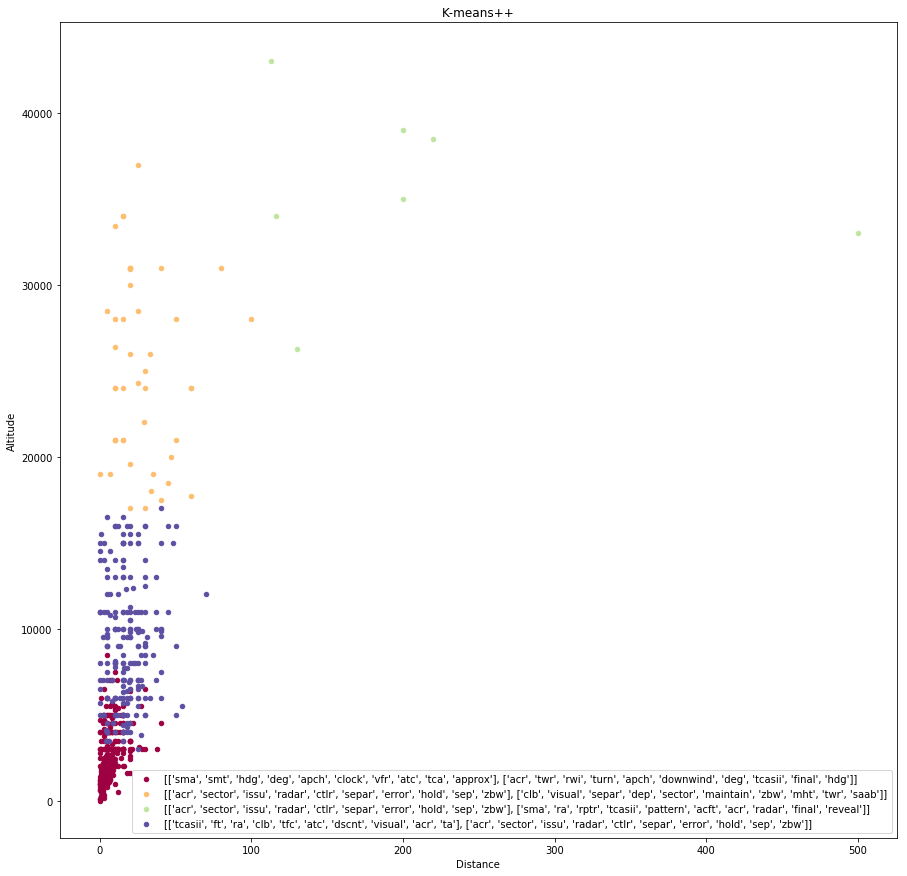

In [142]:
# Plot k-means++
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Klabels)) if Klabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Klabels)) if Klabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, color=colors[cluster_index], label = Kcluster_names[cluster_index], s=20)
    
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('K-means++')
plt.show()

In [127]:
#run this cell to delete outliers and return the kmeans
#outliers(k, Klabels, Kcentroids, Kcluster_names)

1. Traffic Collision Avoidence System / FT / Radar Advisory Service / Climb / Air Traffic Control / Traffic / Visual / accident / descent / true air speed
2. Traffic / Apching / sector (a portion of an itinerary) / Visual / Control / Bradley International Airport / Boston Air Route Traffic Control Center (ZBW) / climb / jet
3. Aircraft / sector / issue / radar / control / separation / error / holding / sep (single Engine Piston) / hdg (Heading Mode The autopilot keeps the nose of the airplane pointed at the magnetic heading bug)
4. aircraft / sma (a type of engine) / traffic / smt (SMT RDL 084 is simply a lead radial, so it is there to let you know when to start your turn) / tower / runaway / approach / clock / hdg (Heading Mode The autopilot keeps the nose of the airplane pointed at the magnetic heading bug) / atc (air traffic control)
5. Traffic / Apching / sector (a portion of an itinerary) / Visual / Control / Bradley International Airport / Boston Air Route Traffic Control Center (ZBW) / climb / jet

The usual flying altitude of an aircraft is 39,000 feet. 
Observation: 
1. The lower the altitude, collision is more likely to happen. 
2. At low altitude collision (< 8,000), from the text analysis we can see they happen with climbing and descent, the parameters which may affect the collision are: true air speed, control of the airplane, heading mode, radar, radar advisory service, visual, and happens frequently among sinle engine piston. 
3. At high altitude collision (8,000 ~ 3,6000), from the text analysis we can see they happen during sector(a portion of an itinerary) or climb, and associates more with the arrangement of the traffic control center and airport, visual may also counts as a factor. 

## Hierarchical

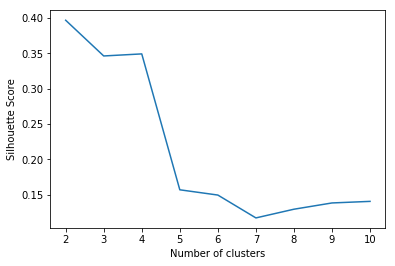

In [102]:
# Find the optimal number of clusters

Z = hierarchy.linkage(df_features, method='ward')
max_clusters = 10
s = np.zeros(max_clusters+1) 

for k in range(2,max_clusters+1):
    clusters = hierarchy.fcluster(Z, k, criterion='maxclust')
    s[k] = metrics.silhouette_score(df_features,clusters,metric='euclidean')
    
plt.plot(range(2,len(s)),s[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

From the graph above, we can see that when number of clusters is 4, the silhouette score is the highest beside 2. So we choose cluster number to be 4.

In [104]:
k = 4
euclidean = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean').fit(df_features)
Hlabels = euclidean.labels_
print(Hlabels.shape)

(571,)


In [105]:
# Find centroids for each cluster
def find_centroids(k, label):
    centroids = []
    for cluster_label in range(k):
        features_list = [df_features.values[index] for index in range(len(label)) if label[index] == cluster_label]
        sum_features = np.sum(features_list, axis=0)
        mean_features = [x/len(features_list) for x in sum_features]
        centroids.append(mean_features)
    return np.array(centroids)
Hcentroids = find_centroids(k, Hlabels)

In [106]:
# Name k Hierarchical clusters
Hasc_order_centroids = Hcentroids.argsort()#[:, ::-1]
Horder_centroids = Hasc_order_centroids[:,::-1]
Horder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Horder_centroids]) # remove locations

Hcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Horder_centroids[i, :2]]
    Hcluster_names.append(label)

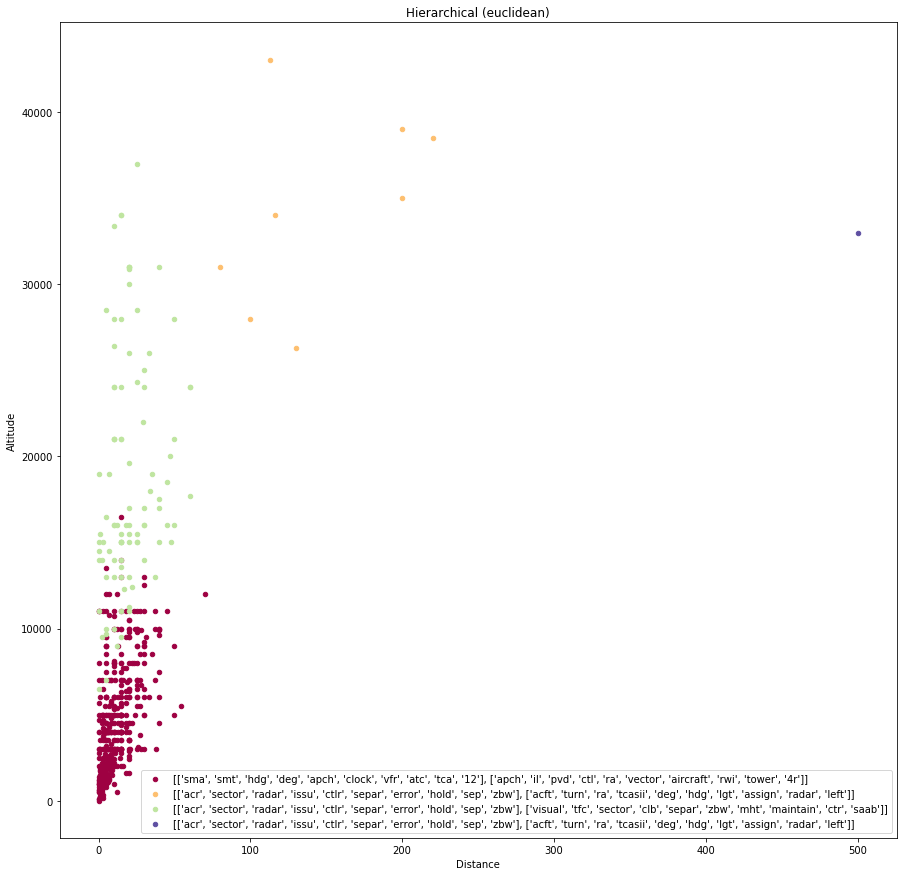

In [108]:
# Plot Hierarchical
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Hlabels)) if Hlabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Hlabels)) if Hlabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, c=colors[cluster_index], label = Hcluster_names[cluster_index], s=20)

plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('Hierarchical (euclidean)')
plt.show()

## GMM

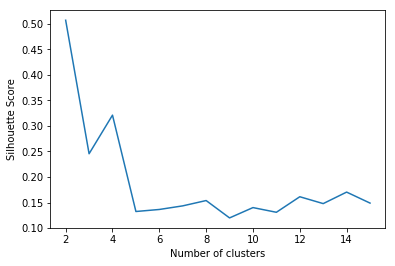

In [170]:
# Find the optimal number of components
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0; 
    for k in range(2,max_clusters+1):
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='spherical')
        gmm.fit(X)
        y_pred = gmm.predict(X)
        s[k] = metrics.silhouette_score(X, y_pred, metric='euclidean')
        
    plt.plot(range(2,len(s)),s[2:]) 
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

sc_evaluate_clusters(df_features, 15)

Based the graph above, we can find that when the number of clusters is 6, the function has the most accurate result beside 2.

In [171]:
k = 4
gmm = mixture.GaussianMixture(n_components=k, covariance_type='spherical')
gmm.fit(df_features)
Gcentroids = gmm.means_
Glabels = gmm.predict(df_features)
print(Glabels.shape)

(571,)


In [172]:
# Name k GMM clusters
Gasc_order_centroids = Gcentroids.argsort()#[:, ::-1]
Gorder_centroids = Gasc_order_centroids[:,::-1]
Gorder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Gorder_centroids]) # remove locations

Gcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Gorder_centroids[i, :2]]
    Gcluster_names.append(label)

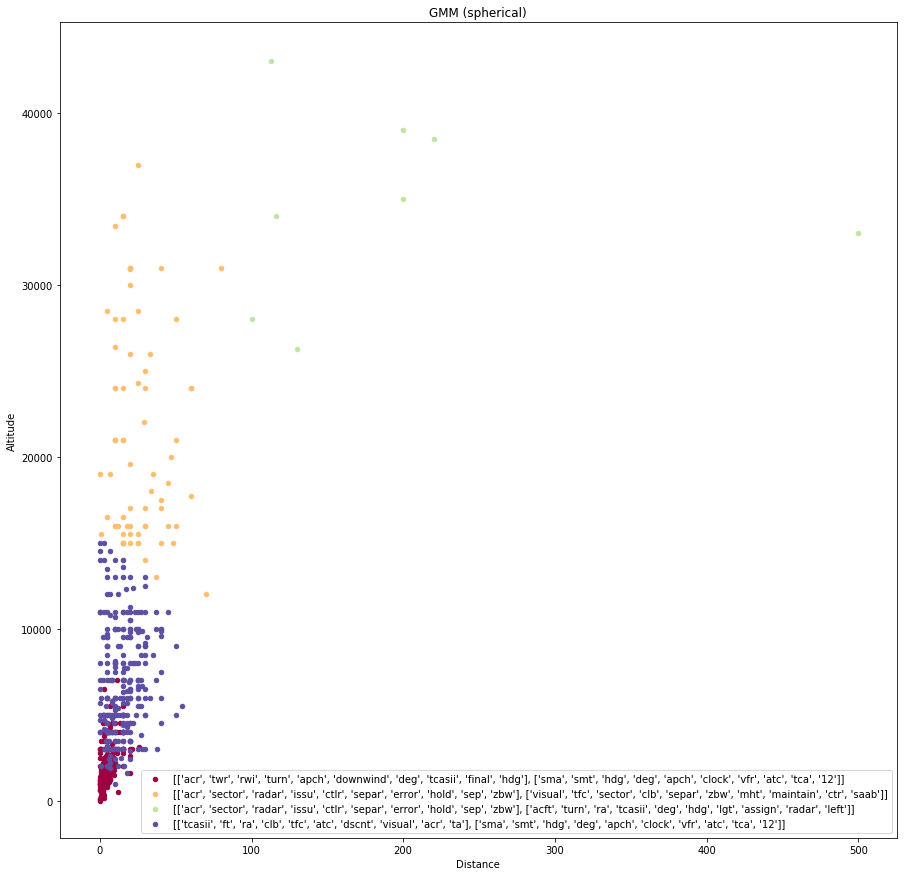

In [173]:
# Plot GMM
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Glabels)) if Glabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Glabels)) if Glabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, c=colors[cluster_index], label = Gcluster_names[cluster_index], s=20)

plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('GMM (spherical)')
plt.show()

## Analysis

### Latent Semantic Analysis
##### Parameters
- Explain deciding n_components
- scale location (we do not want the location vectors to be too dominant to make the text features meaningless)

##### Full forms of the above abbreviations
Full forms of the above abbreviations:
1. 
2. 
3. 
4.
5.
1. aircaft, error, standard, system, separation, between, Less Than Standard Separation
2. control, boston air route traffic control center, experience, operator, at, separation, standard, feet
3. Traffic Alert and Collision Avoidance, to, alert, aircaft, Resolution Advisory, Less Than Standard Separation, assign, descdent
4. runways, on, aircraft, approach, experience, Less Than Standard Separation, operator, error
5. Resolution Advisory, Traffic Alert and Collision Avoidance, report, crew, aircraft, approach runway, control

1. Near mid air collision, , , Pattern
2. aircraft, error, standard, Near mid air collision,
3. separate, 
4.
5.

### Clustering
##### Parameters
Explain Some variable we play around with:
- k number of clusters

##### Results
1. midair collision sma has pattern / less than standard separation system error oppuacied
2. aircarrier error standard midair collision / in separate standard aircraft
3. nmac operator

##### K-means, Hierarchical and GMM